# Overview

This project aims to predict customer churn based on a set of anonymized features (X1 - X8). 

The average amount of time before a customer cancels their subscription to the service is 196 days, or about 6.5 months. The median time is 125 days, or about 4 months. With these statistics in mind, any customers with sign-up dates less than 5 months prior to January 14th, 2016 have been excluded from modeling, since these customers may not have had time to cancel. Of the 1697 excluded customers, 1367 are active and 330 have canceled already. This leaves 8303 customers for modeling. Of this, 70% (5812) are used to train the model and 30% (2491) are used to test it.

The prediction model used is a Random Forest classifier, an ensemble of decision trees that labels a customer as either 'active' (label = 1) or 'canceled' (label = 0). These labels are determined by the customer status after 6 months. Therefore, **these predictions may be interpreted to mean a customer's likely status after 6 months.**

Accuracy: 0.69 

Classification Report: 

             precision    recall  f1-score   support

          0       0.67      0.66      0.66      1150
          1       0.71      0.73      0.72      1341

avg / total       0.69      0.69      0.69      2491



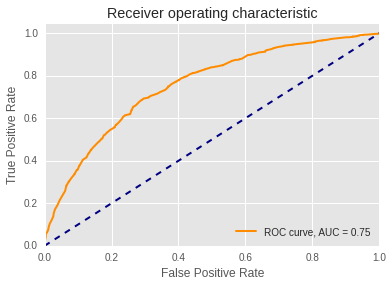

In [75]:
generate_clf_report(X_train,y_train,X_test,y_test,RF)

The terms used in this report:

- True Positive (TP), when a user is correctly predicted to be active after 5 months.
- False Positive (FP), when a user is predicted to be active, but has actually canceled.
- Precision = TP / (TP + FP), the fraction of users labeled as active that are actually active.
- Recall = TP / (TP + FN), also called True Positive Rate, is the fraction of active users correctly identified.

This model has an accuracy of 0.69, meaning that 69% of customers are correctly identified as active or canceled. This is when status is determined by a majority vote within the Random Forest. This value can be considered more holistically by looking at the classification effectiveness for each status label.

For canceled customers:

 - Precision = 0.67
 - Recall = 0.66
 
For active customers:

 - Precision = 0.71
 - Recall = 0.73

The most important predictive features were determined to be X6, X7, and X8.

## ROC

An ROC curve is also given above. This generated by varying the threshold between active and canceled labels within the Random Forest model. It can be used to determine the acceptable number of TP versus FP. The ideal location in the ROC curve is the upper left, where TPR = 1 and FPR = 0. This is where the status of all customers is correctly predicted.

## Timeline Modeling
 
The Random Forest model was adapted to provide a prediction of the customer's status over time. This was done by including the length of subscription (cancel_date - signup_date) as a dependent variable. Two example timelines for specific customers are shown below. **The probability that a customer cancels drops off sharply after about 6 months.**

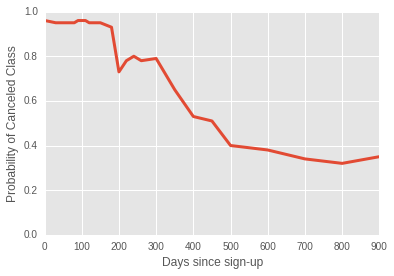

In [76]:
cancel_timeline(8380,RF_time)

This customer's actual subscription length was about 580 days.

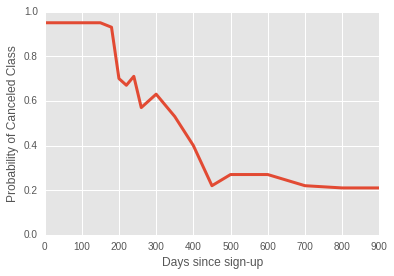

In [79]:
cancel_timeline(7589,RF_time)

This customer's actual subscription length was about 180 days.

# Code and Analysis

## Initialization

In [1]:
import pandas as pd
import numpy as np

In [16]:
import seaborn as sns

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, classification_report, mean_squared_error, roc_auc_score
from sklearn import cross_validation
from sklearn.neighbors import KNeighborsClassifier

In [5]:
%pylab inline
matplotlib.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [6]:
df = pd.read_csv('data-science-project.csv',parse_dates=[0,2])

In [7]:
canceled = df[ df.status == "canceled" ]
active = df[ df.status == "active" ]

In [8]:
print "Average subscription length:", (canceled.cancel_date - canceled.signup_date).mean()
print "Median subscription length:", (canceled.cancel_date - canceled.signup_date).median()
print "Average length of membership for active customers:", (pd.to_datetime('Jan 14, 2016') - active.signup_date).mean()

Average subscription length: 196 days 18:22:13.998752
Median subscription length: 125 days 00:00:00
Average length of membership for active customers: 337 days 20:01:19.419448


Sign-up dates less than ~ 4-6 months before January 14, 2016 may not provide reliable information. These data points are excluded from modeling.

In [9]:
print "Number of users excluded:", len(df[ df.signup_date >= pd.to_datetime('Aug 14, 2015')])
print "Number of active users excluded:", len(df[ (df.signup_date >= pd.to_datetime('Aug 14, 2015')) & (df.status == "active")])
print "Number of canceled users excluded:", len(df[ (df.signup_date >= pd.to_datetime('Aug 14, 2015')) & (df.status == "canceled")])

Number of users excluded: 1697
Number of active users excluded: 1367
Number of canceled users excluded: 330


In [10]:
#status = df[ df.signup_date < pd.to_datetime('Aug 14, 2015')].copy()
status = df.copy()

In [11]:
status.head()

,signup_date,status,cancel_date,X1,X2,X3,X4,X5,X6,X7,X8
0,2015-03-17,canceled,2015-06-13,1.33,<NA>,8dda9d7a,822f8500,7ee164d9,0.52,NaN,2.00
1,2013-12-19,canceled,2015-01-05,0.33,<NA>,f4a15c3f,40183e04,2ea67079,NaN,NaN,4.33
2,2014-07-29,canceled,2014-10-29,1.00,<NA>,ab153736,d27e54e5,4b29bcce,2.75,0.50,14.75
3,2015-09-30,canceled,2015-12-30,1.33,416e1394,87109cbe,ba2bc7b6,91d78334,1.72,0.95,3.08
4,2014-06-11,canceled,2014-12-11,1.00,<NA>,f4a15c3f,40183e04,7ee164d9,0.39,1.13,2.25


In [12]:
status.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
signup_date    10000 non-null datetime64[ns]
status         10000 non-null object
cancel_date    6460 non-null datetime64[ns]
X1             10000 non-null float64
X2             10000 non-null object
X3             10000 non-null object
X4             10000 non-null object
X5             10000 non-null object
X6             7245 non-null float64
X7             7087 non-null float64
X8             7446 non-null float64
dtypes: datetime64[ns](2), float64(4), object(5)
memory usage: 859.4+ KB


In [13]:
len(status[ status.status == "canceled"])

6555

Some customers who have canceled the service are missing cancellation dates. There are also values missing for X6, X7, and X8. 

## Data Munging
### Imputation, Dummy Variables

#### Map 'status' to binary variables

In [14]:
status.status = df.status.map({'canceled': 0, 'active': 1})
status.status.value_counts()

0    6555
1    3445
Name: status, dtype: int64

count    10000.000000
mean         1.056501
std          0.232138
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: X1, dtype: float64


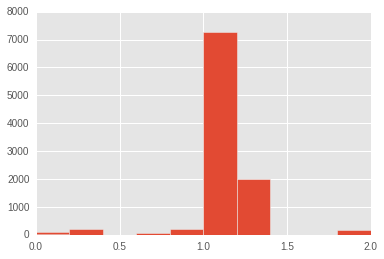

In [18]:
print status.X1.describe()
status.X1.hist()
#sns.countplot(y="X1",data=status)

#### Simplify categorical variables X2 - X5 by grouping

In [19]:
status.X2 = df.X2.map({'416e1394': 'X2_1', 'fd76e8b1': 'X2_2', '955c0cfc': 'X2_3'})
status.X2.fillna('X2_None', inplace=True)
print df.X2.value_counts()
print '\n'
print status.X2.value_counts()

<NA>        8395
416e1394    1424
fd76e8b1     135
955c0cfc      46
Name: X2, dtype: int64


X2_None    8395
X2_1       1424
X2_2        135
X2_3         46
Name: X2, dtype: int64


In [20]:
status.X3 = df.X3.map({'f4a15c3f': 'X3_1', '8672e9aa': 'X3_2', 'ab153736': 'X3_3'})
status.X3.fillna('X3_Other', inplace=True)
#print df.X3.value_counts()
print status.X3.value_counts()

X3_Other    5536
X3_1        1918
X3_2        1334
X3_3        1212
Name: X3, dtype: int64


In [21]:
status.X4 = df.X4.map({'6f749b17': 'X4_1', '822f8500': 'X4_2', 'ba2bc7b6': 'X4_3'})
status.X4.fillna('X4_Other', inplace=True)
status.X4.value_counts()

X4_1        3714
X4_Other    3120
X4_2        1828
X4_3        1338
Name: X4, dtype: int64

In [22]:
status.X5 = df.X5.map({'4b29bcce': 'X5_1', '7ee164d9': 'X5_2', '91d78334': 'X5_3'})
status.X5.fillna('X5_Other', inplace=True)
status.X5.value_counts()

X5_1        4648
X5_2        2731
X5_3        2239
X5_Other     382
Name: X5, dtype: int64

#### Impute missing values for X6 - X8 by using mean values, take natural log to reduce skewness

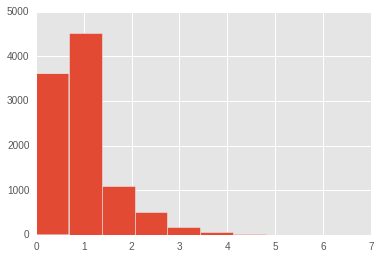

In [23]:
status.X6 = np.log1p(df.X6)
status['X6_impute_fl'] = (status.X6.isnull()).astype(int)
status.X6.fillna(status.X6.mean(),inplace=True)
status.X6.hist()

960.56 3.2162705314 14.0411759856


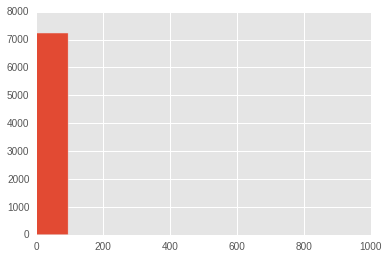

In [24]:
print df.X6.max(), df.X6.mean(), df.X6.std()
df.X6.hist()

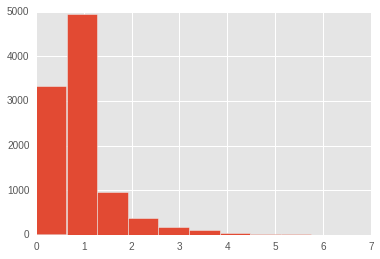

In [25]:
status.X7 = np.log1p(df.X7)
status['X7_impute_fl'] = (status.X7.isnull()).astype(int)
status.X7.fillna(status.X7.mean(),inplace=True)
status.X7.hist()

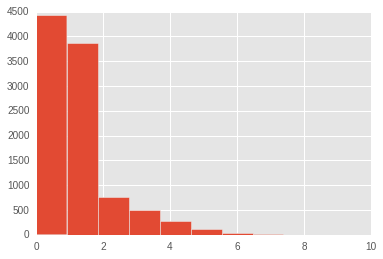

In [26]:
status.X8 = np.log1p(df.X8)
status['X8_impute_fl'] = (status.X8.isnull()).astype(int)
status.X8.fillna(status.X8.mean(),inplace=True)
status.X8.hist()

In [27]:
# Skew has been reduced
print df.X1.skew(), status.X1.skew()
print df.X6.skew(), status.X6.skew()
print df.X7.skew(), status.X7.skew()
print df.X8.skew(), status.X8.skew()

-0.0363141433498 -0.0363141433498
46.739080507 1.46770499326
17.3314829151 2.13448828427
48.4997062579 1.93641623069


In [28]:
status.cancel_date.min()

Timestamp('1969-12-31 00:00:00')

This is obviously an error in the data.

In [29]:
status[ status.cancel_date.min() == status.cancel_date ]

,signup_date,status,cancel_date,X1,X2,X3,X4,X5,X6,X7,X8,X6_impute_fl,X7_impute_fl,X8_impute_fl
5328,2013-02-22,0,1969-12-31,1.0,X2_None,X3_Other,X4_Other,X5_1,0.922047,0.910079,1.221525,1,1,1


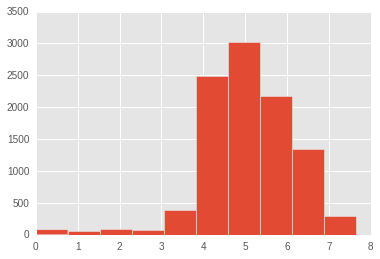

In [30]:
status['sub_length'] = pd.DataFrame(((status.cancel_date - status.signup_date)/np.timedelta64(1,'D')),index=status.index)
status['sub_length'].fillna((pd.to_datetime('Jan 14 2016') - status.signup_date)/np.timedelta64(1,'D'),inplace=True)

status.loc[5328,'sub_length'] = 0
status['sub_length'] = np.log1p(status['sub_length'])
status['sub_length'].hist()

## EDA

Some exploration of the data.

/home/dcarmody/anaconda2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


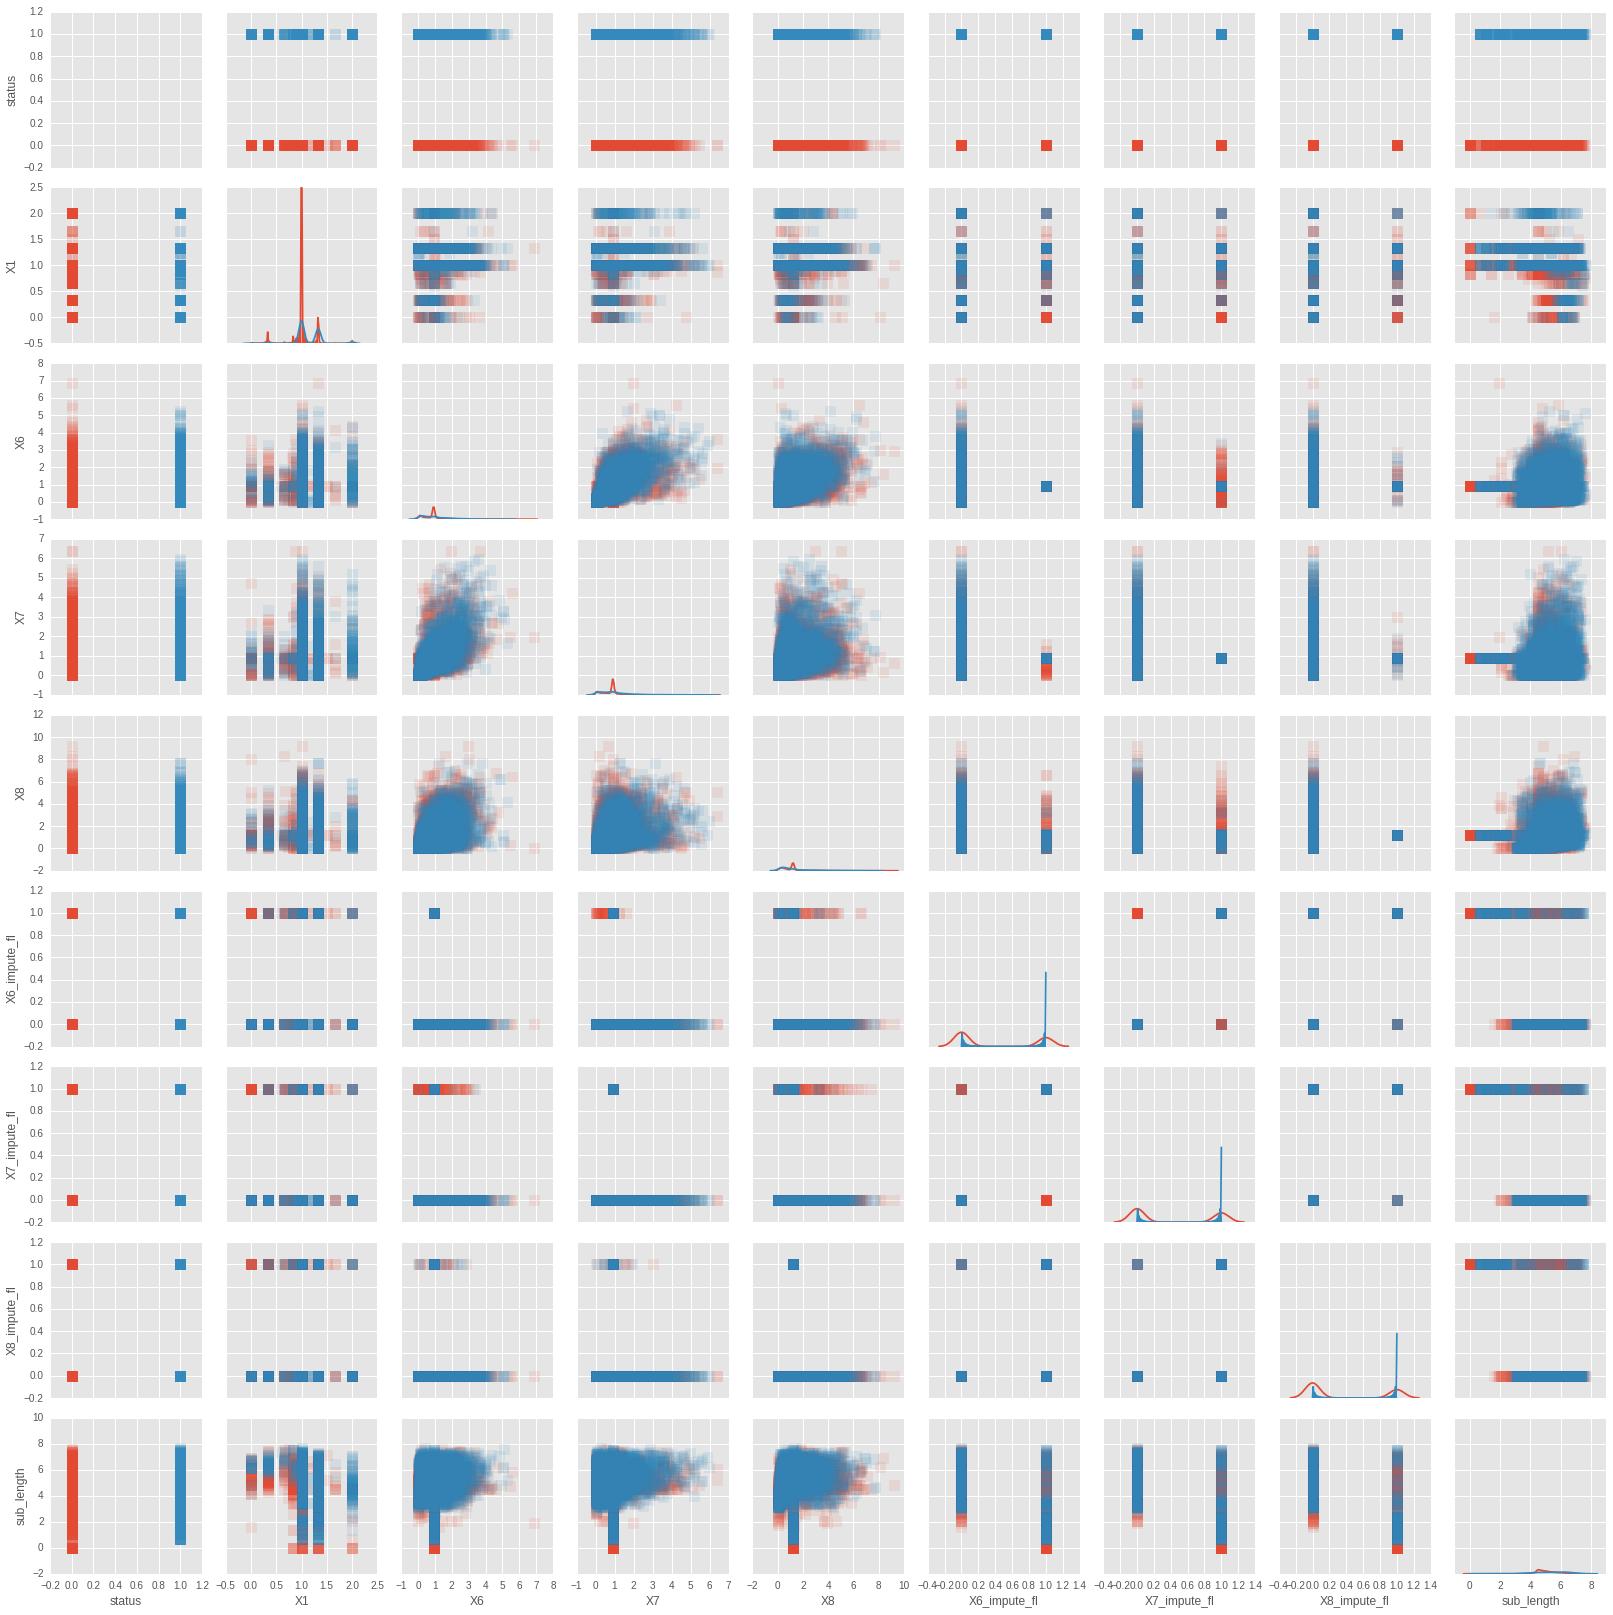

In [31]:
g = sns.PairGrid(status, hue='status')
g = g.map_offdiag(plt.scatter, alpha=0.1, marker='s', s=100)
g = g.map_diag(sns.kdeplot)

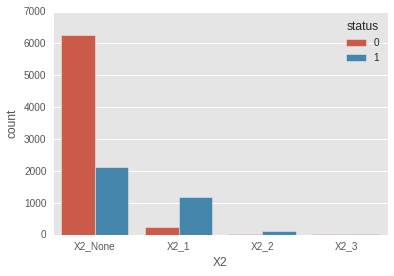

In [32]:
sns.countplot(x="X2",hue="status",data=status)

Removing newer customers eliminates the existence of the X2_3 variable.

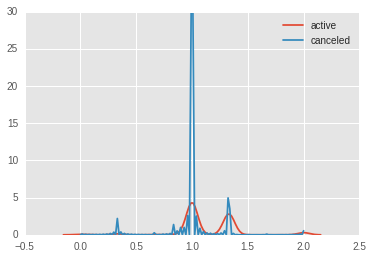

In [33]:
sns.kdeplot(active.X1,label="active")
sns.kdeplot(canceled.X1,label="canceled")

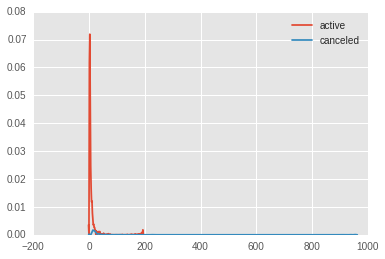

In [34]:
sns.kdeplot(active.X6,label="active")
sns.kdeplot(canceled.X6,label="canceled")

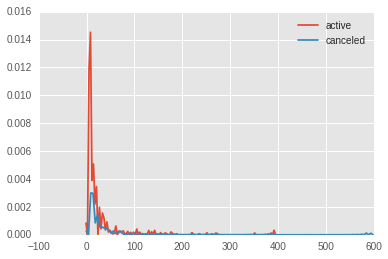

In [35]:
sns.kdeplot(active.X7,label="active")
sns.kdeplot(canceled.X7,label="canceled")

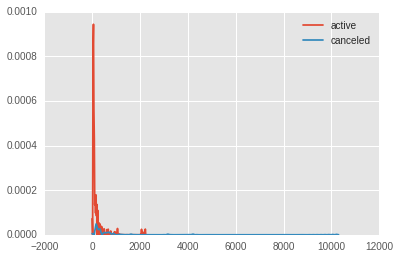

In [36]:
sns.kdeplot(active.X8,label="active")
sns.kdeplot(canceled.X8,label="canceled")

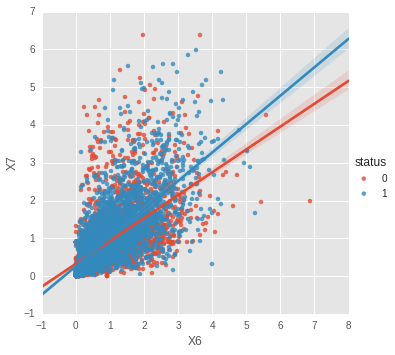

In [37]:
sns.lmplot(x="X6",y="X7",hue="status",data=status)

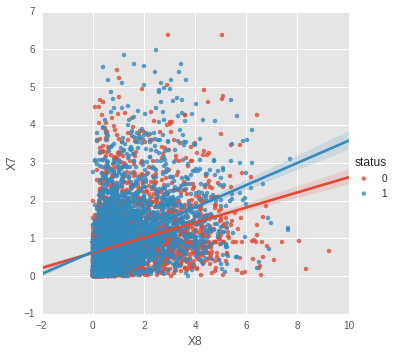

In [38]:
sns.lmplot(x="X8",y="X7",hue="status",data=status)

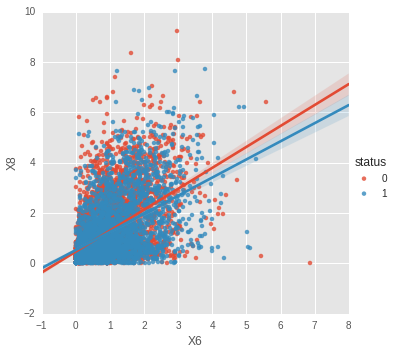

In [39]:
sns.lmplot(x="X6",y="X8",hue="status",data=status)

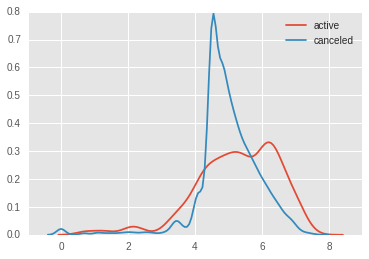

In [40]:
sns.kdeplot(status[ status.status == 1].sub_length, label="active")
sns.kdeplot(status[ status.status == 0].sub_length, label="canceled")

(-100, 600)

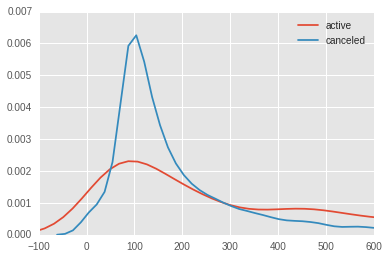

In [41]:
sns.kdeplot(np.expm1(status[ status.status == 1].sub_length), label="active")
sns.kdeplot(np.expm1(status[ status.status == 0].sub_length), label="canceled")
xlim(-100,600)

## Feature Engineering

There may be some correlation between the variance of X6/X7/X8 and cancellation.

In [42]:
status['variance'] = [var(x) for x in zip(status.X6,status.X7,status.X8)]

# Prediction

- status = 0 indicates 'canceled'
- status = 1 indicates 'active

In [43]:
status.head()

,signup_date,status,cancel_date,X1,X2,X3,X4,X5,X6,X7,X8,X6_impute_fl,X7_impute_fl,X8_impute_fl,sub_length,variance
0,2015-03-17,0,2015-06-13,1.33,X2_None,X3_Other,X4_2,X5_2,0.418710,0.910079,1.098612,0,1,0,4.488636,0.082139
1,2013-12-19,0,2015-01-05,0.33,X2_None,X3_1,X4_Other,X5_Other,0.922047,0.910079,1.673351,1,1,0,5.948035,0.127465
2,2014-07-29,0,2014-10-29,1.00,X2_None,X3_3,X4_Other,X5_1,1.321756,0.405465,2.756840,0,0,0,4.532599,0.936447
3,2015-09-30,0,2015-12-30,1.33,X2_1,X3_Other,X4_3,X5_3,1.000632,0.667829,1.406097,0,0,0,4.521789,0.091133
4,2014-06-11,0,2014-12-11,1.00,X2_None,X3_1,X4_Other,X5_2,0.329304,0.756122,1.178655,0,0,0,5.214936,0.120234


In [44]:
features = ['X1','X2','X3','X4','X5','X6','X7','X8','X6_impute_fl','X7_impute_fl','X8_impute_fl','variance']
#features = ['X1','X2','X3','X4','X5','X6','X7','X8']
#features = ['X1','X2','X3','X4','X5']
#features = ['X6','X7','X8']

In [45]:
#status.status = df.status.map({'canceled': 0, 'active': 1})
# Or, map status based on status after 6 months
# If subscription length is greater than 180 days, label user as active
status.ix[ np.expm1(status.sub_length) > 180, 'status'] = 1

In [46]:
df.status.value_counts()

canceled    6555
active      3445
Name: status, dtype: int64

In [47]:
status.status.value_counts()

1    5964
0    4036
Name: status, dtype: int64

In [48]:
use_data = status[ status.signup_date < pd.to_datetime('Aug 14, 2015')]
#use_data = status
dummies = pd.get_dummies(use_data[features])

In [49]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(dummies, use_data.status, test_size=0.3)

In [50]:
def norm(data):
    return (data - data.mean())/(data.max() - data.min())

In [51]:
def generate_clf_report(X_train,y_train,X_test,y_test,mod):
    lw = 2

    mod.fit(X_train,y_train)
    
    print "Accuracy: %0.2f \n" % mod.score(X_test,y_test)
    
    pred = mod.predict(X_test)
    print "Classification Report: \n"
    print classification_report(pred, y_test)
    
    pred_prob = mod.predict_proba(X_test)
    
    fpr, tpr, _ = roc_curve(y_test,pred_prob[:,1])
    auc = roc_auc_score(y_test,pred_prob[:,1])
    plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve, AUC = %0.2f' % auc )

    plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    xlim([0.0, 1.0])
    ylim([0.0, 1.05])
    xlabel('False Positive Rate')
    ylabel('True Positive Rate')
    title('Receiver operating characteristic')
    legend(loc="lower right")

## Random Forest

In [52]:
RF = RandomForestClassifier(n_estimators=100)

Accuracy: 0.70 

Classification Report: 

             precision    recall  f1-score   support

          0       0.67      0.66      0.67      1137
          1       0.72      0.73      0.72      1354

avg / total       0.70      0.70      0.70      2491



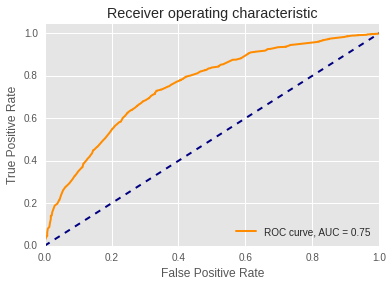

In [54]:
generate_clf_report(X_train,y_train,X_test,y_test,RF)

In [55]:
feat_imp = zip(RF.feature_importances_, dummies.columns)
print "Feature Importance: \n"
for i,f in sorted(feat_imp,reverse=True):
    print "%s (%0.2f)" % (f,i)

Feature Importance: 

X8 (0.19)
variance (0.18)
X6 (0.17)
X7 (0.16)
X1 (0.05)
X7_impute_fl (0.04)
X6_impute_fl (0.03)
X4_X4_Other (0.02)
X4_X4_2 (0.02)
X3_X3_Other (0.02)
X8_impute_fl (0.02)
X5_X5_2 (0.02)
X3_X3_1 (0.01)
X5_X5_1 (0.01)
X4_X4_1 (0.01)
X3_X3_2 (0.01)
X3_X3_3 (0.01)
X5_X5_3 (0.01)
X4_X4_3 (0.01)
X5_X5_Other (0.01)
X2_X2_2 (0.00)
X2_X2_None (0.00)
X2_X2_1 (0.00)


## SVC

Accuracy: 0.67 

Classification Report: 

             precision    recall  f1-score   support

          0       0.55      0.66      0.60       930
          1       0.77      0.68      0.72      1561

avg / total       0.69      0.67      0.67      2491



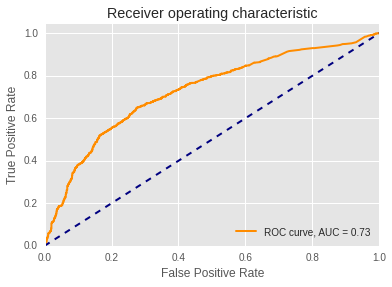

In [56]:
svc = SVC(probability=True)

generate_clf_report(X_train,y_train,X_test,y_test,svc)

## K-nearest neighbors

Accuracy: 0.67 

Classification Report: 

             precision    recall  f1-score   support

          0       0.61      0.63      0.62      1083
          1       0.71      0.69      0.70      1408

avg / total       0.67      0.67      0.67      2491



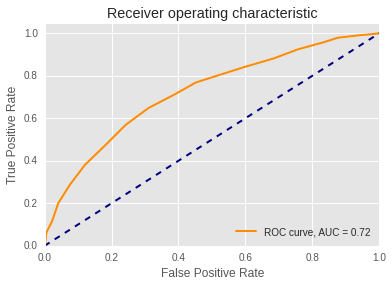

In [57]:
knn = KNeighborsClassifier(n_neighbors=20)
generate_clf_report(X_train,y_train,X_test,y_test,knn)
#mod = RandomForestClassifier()
#generate_clf_report(Xc_train,yc_train,Xc_test,yc_test,mod)

## Ensemble

In [58]:
pred_prob = (knn.predict_proba(X_test) + RF.predict_proba(X_test) + svc.predict_proba(X_test))/3

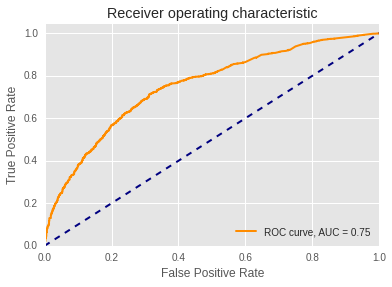

In [60]:
fpr, tpr, _ = roc_curve(y_test,pred_prob[:,1])
auc = roc_auc_score(y_test,pred_prob[:,1])
plot(fpr, tpr, color='darkorange',lw=2, label='ROC curve, AUC = %0.2f' % auc )

plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
xlim([0.0, 1.0])
ylim([0.0, 1.05])
xlabel('False Positive Rate')
ylabel('True Positive Rate')
title('Receiver operating characteristic')
legend(loc="lower right")

## Cancellation likliehood timeline

This model includes the length of a customer's subscription as a predictive feature and uses that quantity as an independent variable that may be used to identify a customer's likeliehood of cancellation over time.

In [61]:
features = ['X1','X2','X3','X4','X5','X6','X7','X8','X6_impute_fl','X7_impute_fl','X8_impute_fl','variance','sub_length']

status.status = df.status.map({'canceled': 0, 'active': 1})
use_data = status # use all available data

dummies = pd.get_dummies(use_data[features])

Xt_train, Xt_test, yt_train, yt_test = cross_validation.train_test_split(dummies, use_data.status, test_size=0.3)

In [62]:
RF_time = RandomForestClassifier(n_estimators=100)
RF_time.fit(Xt_train,yt_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [63]:
Xt_test.head()

,X1,X6,X7,X8,X6_impute_fl,X7_impute_fl,X8_impute_fl,variance,sub_length,X2_X2_1,...,X3_X3_3,X3_X3_Other,X4_X4_1,X4_X4_2,X4_X4_3,X4_X4_Other,X5_X5_1,X5_X5_2,X5_X5_3,X5_X5_Other
8380,0.33,0.431782,0.385262,0.604316,0,0,0,0.008880,6.359574,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1835,1.00,0.922047,0.910079,1.221525,1,1,1,0.020759,1.098612,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
5100,1.00,2.070653,1.297463,2.596746,0,0,0,0.284748,7.089243,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7589,0.66,0.425268,0.438255,0.652325,0,0,0,0.010839,5.204007,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9704,0.33,0.405465,0.662688,0.604316,0,0,0,0.012124,5.981414,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [64]:
def cancel_timeline(Xloc,mod):
    timeline = [1,30,60,70,80,90,100,110,120,150,180,200,220,240,260,300,350,400,450,500,600,700,800,900]
    scores_c = []
    scores_a = []
    for time in timeline:
        Xt_test.loc[Xloc,'sub_length'] = np.log1p(time)
        scores_c.append(mod.predict_proba(Xt_test.loc[Xloc].reshape(1,-1))[0][0])
        scores_a.append(mod.predict_proba(Xt_test.loc[Xloc].reshape(1,-1))[0][1])
    plot(timeline,scores_c,lw=3)
    xlabel('Days since sign-up')
    ylabel('Probability of Canceled Class')
    ylim(0,1)

In [65]:
# Order of classes
RF_time.classes_

array([0, 1])

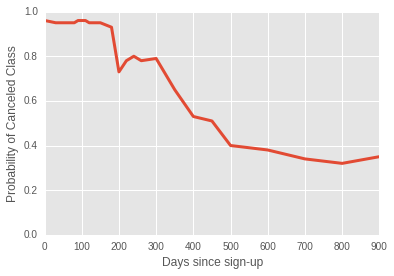

In [68]:
cancel_timeline(8380,RF_time)

In [77]:
print df.status.iloc[8380]
print np.expm1(status.iloc[8380].sub_length)

canceled
577.0


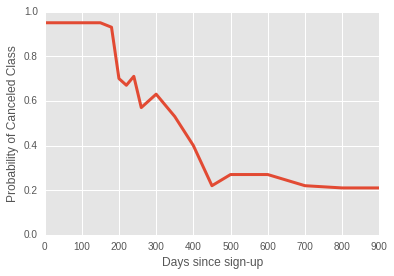

In [71]:
cancel_timeline(7589,RF_time)

In [78]:
print df.status.iloc[7589]
print np.expm1(status.iloc[7589].sub_length)

canceled
181.0


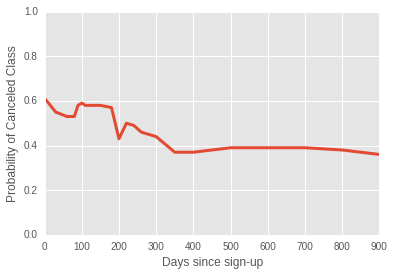

In [73]:
cancel_timeline(9705,RF_time)

In [74]:
np.expm1(status.iloc[9705].sub_length)

421.99999999999983